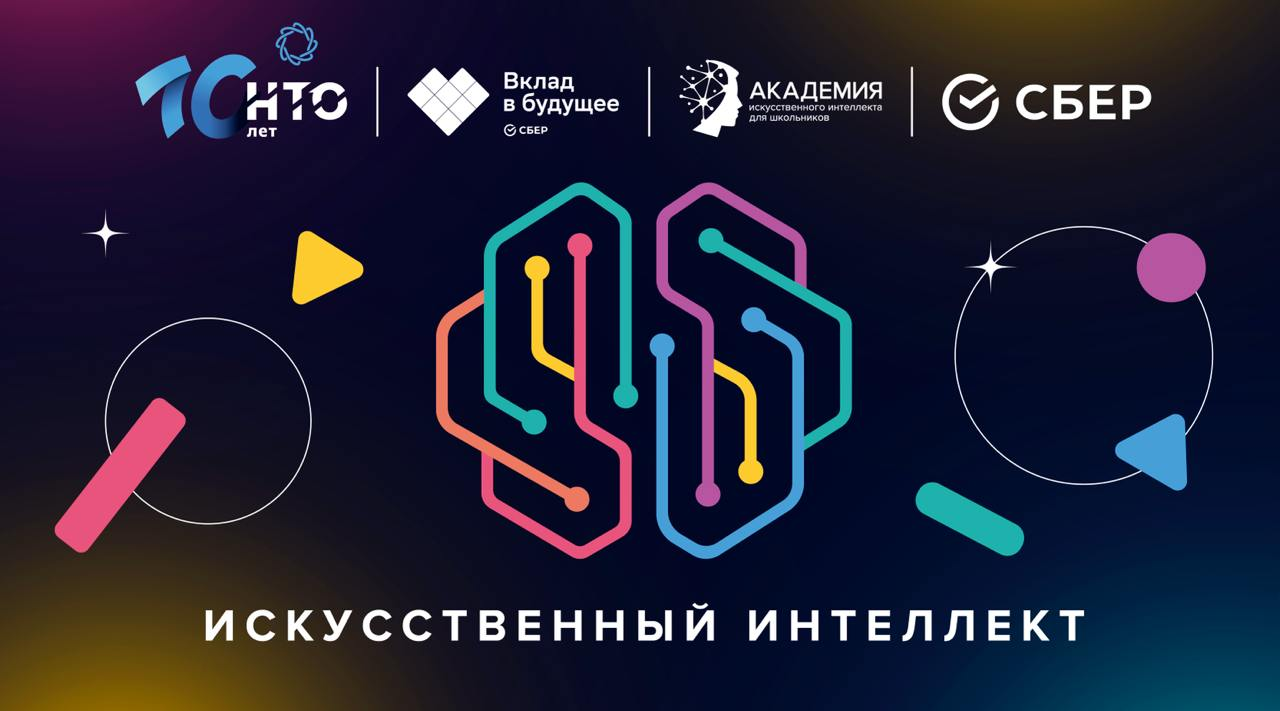

# Baseline для детекции животных по фотографии
Перед вами базовое решение, позволяющие обучить модель машинного обучения обучения для обнаружения животных на фотографиях и определения его группы.
В данном ноутбуке также приведен пример формирования файла с предсказаниями работы модели, на основании которого проводится оценка предсказания модели.

Под задачей детекции животных на изображении понимается задача машинного обучения, в рамках которой выполняется определение наличия или отсутствия животного на изображении, нахождение границ этого животного в системе координат пикселей исходного изображения и определение группы животного.

Код ниже состоит из четырёх основных частей:

- Установка и импорт библиотек, требуемых для работы
- Исследовательский анализ данных
- Подготовка данных для обучения модели  YOLO
- Обучение базовой модели
- Запуск модели и формирование сабмита.


# Установка и импорт библиотек

In [1]:
import torch
torch.cuda.is_available()

True

In [2]:
# !pip install imgviz ultralytics pyyaml

In [3]:

# Загрузка необходимых библиотек для обучения YOLO
import pandas as pd
import seaborn as sns
import matplotlib
import matplotlib.pyplot as plt

from os import listdir
from pathlib import Path
from shutil import copy
import argparse
import pandas as pd
from tqdm import tqdm
from ultralytics import YOLO

import os

import numpy as np
import imgviz
from PIL import Image
from numpy import asarray

from shutil import copy
from sklearn.model_selection import train_test_split

import argparse
import shutil


# Исследовательский анализ данных




Данные содержат информацию:
- image_name - название файла
- detection - координаты ограничивающего прямоугольника (bounding box)
        в формате "label_1 cx_1 cy_1 w_1 h_1;label_2 cx_2 cy_2 w_2 h_2; ... ;label_n cx_n cy_n w_n h_n",
        где label_i - класс, к которому относится животное, (cx_i, cy_i) - координата центра i-го прямоугольника (в относительных значениях), a w_i, h_i - ширена и высота i-го прямоугольника (в относительных значениях).


In [4]:
# Загрузка csv файла с аннотациями.
train_df_path = "data/train.csv"
train_images_dir = "data/train"

train_df = pd.read_csv(train_df_path)
train_df.head()

image_name  \
0  d4b681c636be92a99d2169685169ddce.JPG   
1  af429cc238c384111b2f6e4ace00638c.JPG   
2  2329fe3d86fa593db201c3897ad74d4c.JPG   
3  309c121c529fb223e87ac1ea9d43073c.JPG   
4  9060b55db1f35ce70948388b0e0158ba.JPG   

                                           detection  
0  4 0.5298713445663452 0.42401960492134094 0.253...  
1  6 0.6738590002059937 0.6928213834762573 0.5684...  
2  1 0.1510416716337204 0.463131308555603 0.23749...  
3  6 0.6556299924850464 0.7617244720458984 0.6808...  
4  5 0.7708333134651184 0.5369875431060791 0.4583...

In [5]:
# Инициализация пустых списков для хранения меток и координат ограничивающих рамок
label_data = []
cx_data, cy_data, w_data, h_data = [], [], [], []

# Проход по каждой строке в обучающем наборе данных
for index, row in train_df.iterrows():
    # Каждая строка (row['detection']) содержит строку с боксами объектов, разделенными точкой с запятой
    for markup in row['detection'].split(";"):
        # Извлекаем метку и координаты ограничивающей рамки (центр x, центр y, ширина, высота)
        label, cx, cy, w, h = markup.split()

        # Преобразуем координаты из строки в число с плавающей точкой для дальнейших вычислений
        cx = float(cx)
        cy = float(cy)
        w = float(w)
        h = float(h)

        # Добавляем метку и координаты ограничивающей рамки в соответствующие списки
        label_data.append(label)
        cx_data.append(cx)
        cy_data.append(cy)
        w_data.append(w)
        h_data.append(h)


<Figure size 640x480 with 0 Axes>

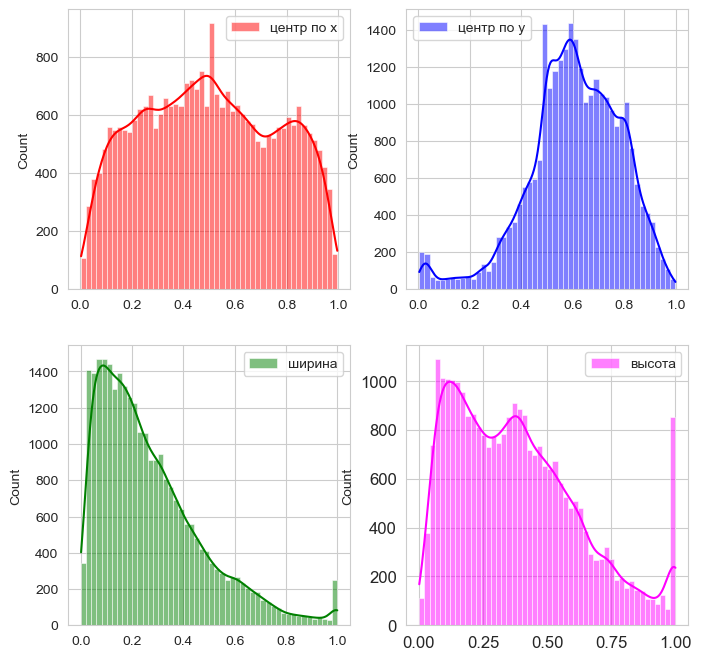

In [6]:
# Установка стиля графиков
sns.set_style('whitegrid')

# Создание фигуры и сетки из подграфиков 2x2 для размещения каждого графика отдельно
plt.figure()
fig, ax = plt.subplots(2, 2, figsize=(8, 8))

# Построение гистограммы распределения координаты центра по оси X с использованием KDE (оценка плотности)
sns.histplot(cx_data, kde=True, bins=50, color="red", ax=ax[0, 0], label='центр по х')

# Построение гистограммы распределения координаты центра по оси Y
sns.histplot(cy_data, kde=True, bins=50, color="blue", ax=ax[0, 1], label='центр по у')

# Построение гистограммы распределения ширины объектов
sns.histplot(w_data, kde=True, bins=50, color="green", ax=ax[1, 0], label='ширина')

# Построение гистограммы распределения высоты объектов
sns.histplot(h_data, kde=True, bins=50, color="magenta", ax=ax[1, 1], label='высота')

# Отображение легенды для каждого графика
ax[0, 0].legend()
ax[0, 1].legend()
ax[1, 0].legend()
ax[1, 1].legend()

# Настройка размеров меток на осях для улучшения читаемости
locs, labels = plt.xticks()
plt.tick_params(axis='both', which='major', labelsize=12)

# Показать графики
plt.show()


In [7]:
# Определение минимального и максимального значений для ширины bounding box
width_data_min = np.min(w_data)
width_data_max = np.max(w_data)

# Определение минимального и максимального значений для высоты bounding box
height_data_min = np.min(h_data)
height_data_max = np.max(h_data)

# Вывод максимального и минимального значений для ширины и высоты bounding box
print(f"Высота bounding box максимальная {height_data_max} и минимальная {height_data_min}")
print(f"Ширина bounding box максимальная {width_data_max} и минимальная {width_data_min}")


Высота bounding box максимальная 1.0 и минимальная 0.0014204978942871094
Ширина bounding box максимальная 1.0 и минимальная 0.00146484375


Давайте посчитаем количество животных на изображении.

In [8]:
def count_bbox(row):
    # Разделяем строку с аннотацией по символу ";", чтобы получить список bounding boxes
    # Возвращаем количество элементов в списке, что соответствует числу bounding boxes
    return len(row.split(";"))


In [9]:
# Применение функции count_bbox к каждому элементу столбца "detection"
# Результат сохраняется в новом столбце "count_bbox"
train_df["count_bbox"] = train_df["detection"].apply(lambda x: count_bbox(x))


<Axes: >

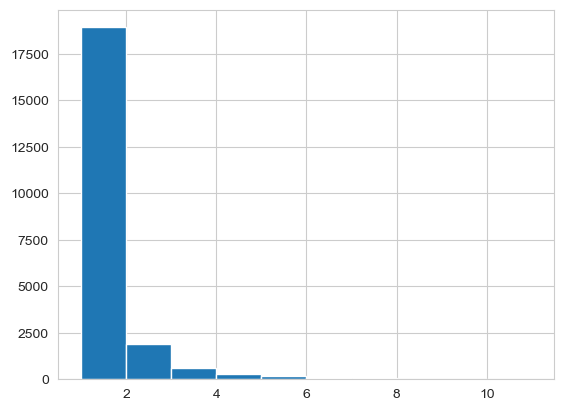

In [10]:
# Построение гистограммы для визуализации распределения количества bounding boxes
train_df["count_bbox"].hist()

In [11]:
MAPPER = ['Заяц', 'Кабан', 'Кошки', 'Куньи', 'Медведь', 'Оленевые', 'Пантеры', 'Полорогие', 'Собачие', 'Сурок']

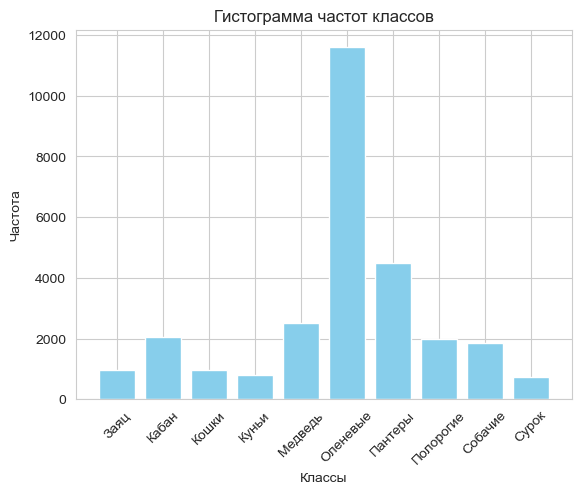

In [12]:
# Подсчет частот каждого уникального класса в датасете
unique, counts = np.unique(label_data, return_counts=True)

# Преобразование меток классов в названия групп с помощью списка MAPPER
labels = []
for id in unique:
    labels.append(MAPPER[int(float(id))])

# Построение гистограммы частот классов
plt.bar(labels, counts, color='skyblue')
plt.xlabel('Классы')  # Метка для оси X
plt.ylabel('Частота')  # Метка для оси Y
plt.title('Гистограмма частот классов')  # Заголовок графика
plt.xticks(labels, rotation=45)  # Установка меток на оси X с поворотом на 45 градусов для лучшей читаемости
plt.show()


## Визуализация ограничивающих прямоугольников

In [13]:
# Функция для визуализации bounding boxes на изображении
def visualize_bbox(img, labels, bboxes, class_names):

    # Создаем подписи для каждого box-а на основе меток классов
    captions = [class_names[label_id] for label_id in labels]

    # Визуализация bounding boxes на изображении с помощью imgviz.instances2rgb
    bbox_viz = imgviz.instances2rgb(
        image=img,                    # Исходное изображение
        bboxes=bboxes,                # Координаты bounding boxes
        labels=labels,                # Метки классов для каждого box-а
        captions=captions,            # Подписи классов
        colormap=imgviz.label_colormap(n_label=10),  # Цветовая карта для классов
        font_size=50,                 # Размер шрифта для подписей
        line_width=10                 # Ширина линии для рамок
    )

    # Отображение изображения с наложенными bounding boxes
    plt.figure(dpi=200)
    plt.imshow(bbox_viz)
    plt.axis("off")  # Убираем оси для лучшей видимости изображения


In [14]:
import os
from PIL import Image
import numpy as np

# Функция для визуализации боксов на изображении по индексу строки в csv файле
def visualization_by_idx(images_dir, train_df, idx, MAPPER):
    # Загружаем изображение
    image_path = os.path.join(images_dir, train_df.loc[idx]["image_name"])
    img = Image.open(image_path)

    # Списки для хранения координат боксов и меток
    bboxes = []
    labels = []

    # Получаем размеры изображения
    img_w, img_h = img.size

    # Парсим аннотации детекции (формат: "метка cx cy w h")
    for markup in train_df.loc[idx]["detection"].split(";"):
        label, cx, cy, w, h = markup.split()
        label = int(label)    # Преобразуем метку в целое число
        cx = float(cx)        # Преобразуем cx в число с плавающей точкой
        cy = float(cy)        # Преобразуем cy в число с плавающей точкой
        w = float(w)          # Преобразуем ширину в число с плавающей точкой
        h = float(h)          # Преобразуем высоту в число с плавающей точкой

        # Преобразуем координаты из относительных (нормализованных) в пиксельные значения
        x1 = int((cx - w / 2) * img_w)  # Левая граница бокса
        x2 = int((cx + w / 2) * img_w)  # Правая граница бокса
        y1 = int((cy - h / 2) * img_h)  # Верхняя граница бокса
        y2 = int((cy + h / 2) * img_h)  # Нижняя граница бокса

        # Добавляем метки и боксы в соответствующие списки
        labels.append(label)
        bboxes.append([y1, x1, y2, x2])  # Формат для визуализации: [y1, x1, y2, x2]

    # Визуализируем изображение с боксовыми аннотациями (предполагается, что функция visualize_bbox уже определена)
    visualize_bbox(np.asarray(img), labels, bboxes, MAPPER)


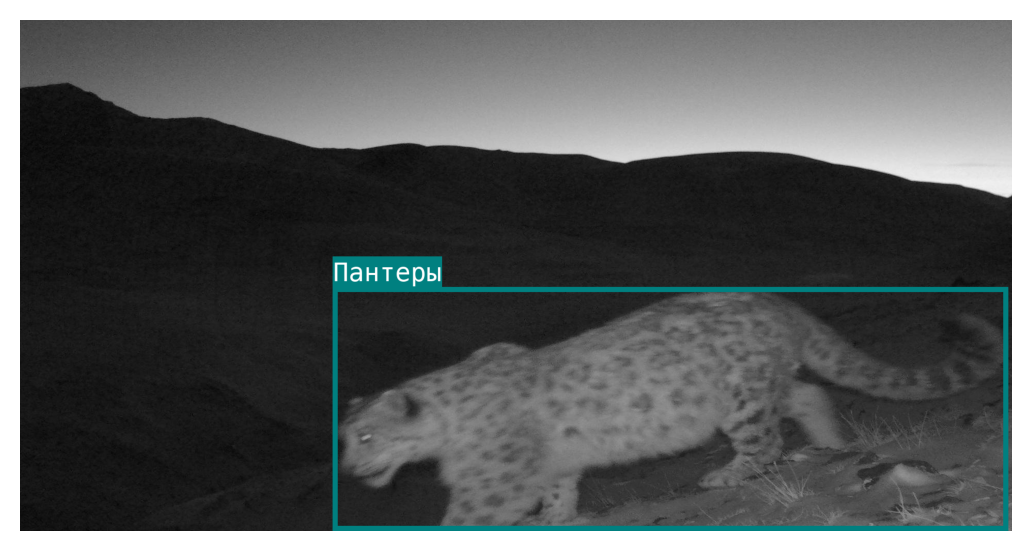

In [15]:
idx = 3 # Индекс строки для визуализации
visualization_by_idx(train_images_dir, train_df, idx, MAPPER)

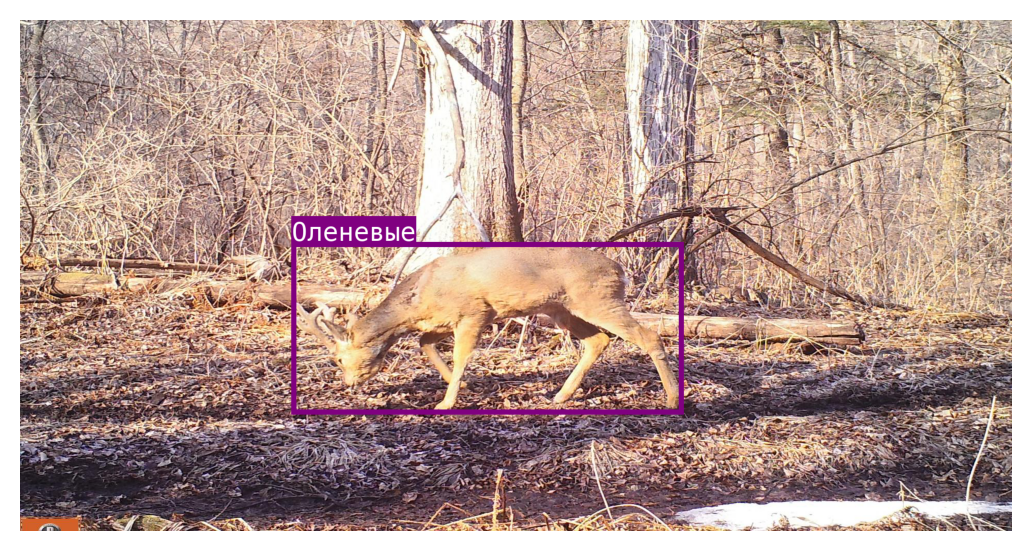

In [16]:
idx = 9 # Индекс строки для визуализации
visualization_by_idx(train_images_dir, train_df, idx, MAPPER)

# Baseline на основе Yolo
## Предподготовка данных для обучения модели для детекции
Для обучения модели Yolo необходимо разбить данные на обучающую и валидационные выборки.
Создать структуру для обучения


In [17]:
def preprocess_markup_yolo(save_path, images_dir, file_name, split, markup):
    # Создаем необходимые директории, если они не существуют
    labels_dir = os.path.join(save_path, "labels", split)
    images_dir_dest = os.path.join(save_path, "images", split)
    os.makedirs(labels_dir, exist_ok=True)
    os.makedirs(images_dir_dest, exist_ok=True)

    # Обработка аннотаций
    yolo_markups = []
    for det in markup.split(";"):
        yolo_markups.append(f"{det}\n")

    # Сохраняем аннотации в файл
    label_file_path = os.path.join(labels_dir, file_name[:-4] + ".txt")
    with open(label_file_path, "w") as f:
        f.writelines(yolo_markups)

    # Копируем изображение в целевую папку
    image_source_path = os.path.join(images_dir, file_name)
    image_dest_path = os.path.join(images_dir_dest, file_name)
    copy(image_source_path, image_dest_path)

In [18]:
def yolo_files_split(data_df_path, yolo_data_dir, images_data_dir):
    # Загружаем данные из CSV
    data_df: pd.DataFrame = pd.read_csv(data_df_path)

    # Разделяем на обучающие и валидационные данные
    data_df_train, data_df_val = train_test_split(data_df, test_size=0.3, random_state=42)

    # Обрабатываем обучающие данные
    for index, row in data_df_train.iterrows():
        preprocess_markup_yolo(yolo_data_dir, images_data_dir, row["image_name"], "train", row["detection"])

    # Обрабатываем валидационные данные
    for index, row in data_df_val.iterrows():
        preprocess_markup_yolo(yolo_data_dir, images_data_dir, row["image_name"], "val", row["detection"])


In [19]:
data_df_path = "data/train.csv"
yolo_data_dir = "yolo/"
images_data_dir = "data/train"

In [20]:
Path("yolo/images/train").mkdir(exist_ok=True, parents=True)
Path("yolo/images/val").mkdir(exist_ok=True, parents=True)
Path("yolo/labels/train").mkdir(exist_ok=True, parents=True)
Path("yolo/labels/val").mkdir(exist_ok=True, parents=True)

In [21]:
yolo_files_split(data_df_path, yolo_data_dir, images_data_dir)

In [22]:
# загрузка необходимых библиотек
import yaml

# Пример данных для конфигурации YOLO
data = {
    'train': 'C:/Python/nto/2024/2_этап_индивидуальный/yolo/images/train',  # путь к обучающим изображениям
    'val': 'C:/Python/nto/2024/2_этап_индивидуальный/yolo/images/val',  # путь к изображениям для валидации
    'nc': 10,  # количество классов
    'names': ['Заяц', 'Кабан', 'Кошки', 'Куньи', 'Медведь', 'Оленевые', 'Пантеры', 'Полорогие', 'Собачие', 'Сурок']  # имена классов
}

# Сохранение данных в YAML файл
with open('yolo/yolo_config.yaml', 'w') as file:
    yaml.dump(data, file, default_flow_style=False, allow_unicode=True)

print("YAML файл успешно создан!")

YAML файл успешно создан!


# Обучение YOLO модели

In [23]:
os.environ['WANDB_MODE'] = 'disabled'

In [24]:
# функция инициализации и обучения модели
def train(model_name, data_yaml):
    model = YOLO(model_name)
    training_results = model.train(
        data=data_yaml,
        epochs=150, # число эпох для обучения
        imgsz=640, # размер изображения для обучения
        batch=16, # размер батча для обучения
        device="cuda", # номер девайса для обучения
        single_cls=False # для обучения с учетом классов на основании data.yaml
    )

In [ ]:
# train("yolov8m.pt", "yolo/yolo_config.yaml")

New https://pypi.org/project/ultralytics/8.3.49 available  Update with 'pip install -U ultralytics'
Ultralytics 8.3.40  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
engine\trainer: task=detect, mode=train, model=yolov8m.pt, data=yolo/yolo_config.yaml, epochs=150, time=None, patience=100, batch=16, imgsz=640, save=True, save_period=-1, cache=False, device=cuda, workers=8, project=None, name=train2, exist_ok=False, pretrained=True, optimizer=auto, verbose=True, seed=0, deterministic=True, single_cls=False, rect=False, cos_lr=False, close_mosaic=10, resume=False, amp=True, fraction=1.0, profile=False, freeze=None, multi_scale=False, overlap_mask=True, mask_ratio=4, dropout=0.0, val=True, split=val, save_json=False, save_hybrid=False, conf=None, iou=0.7, max_det=300, half=False, dnn=False, plots=True, source=None, vid_stride=1, stream_buffer=False, visualize=False, augment=False, agnostic_nms=False, classes=None, retina_masks=False, embed=None, show=False, save_frame

train: Scanning C:\Python\nto\2024\2_этап_индивидуальный\yolo\labels\train... 15454 images, 0 backgrounds, 0 corrupt: 100%|██████████| 15454/15454 [00:31<00:00, 496.61it/s]


train: New cache created: C:\Python\nto\2024\2__\yolo\labels\train.cache


val: Scanning C:\Python\nto\2024\2_этап_индивидуальный\yolo\labels\val.cache... 7286 images, 0 backgrounds, 0 corrupt: 100%|██████████| 7286/7286 [00:00<?, ?it/s]


Plotting labels to runs\detect\train2\labels.jpg... 
optimizer: 'optimizer=auto' found, ignoring 'lr0=0.01' and 'momentum=0.937' and determining best 'optimizer', 'lr0' and 'momentum' automatically... 
optimizer: SGD(lr=0.01, momentum=0.9) with parameter groups 77 weight(decay=0.0), 84 weight(decay=0.0005), 83 bias(decay=0.0)
Image sizes 640 train, 640 val
Using 8 dataloader workers
Logging results to runs\detect\train2
Starting training for 150 epochs...

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      1/150       6.8G     0.6858      1.453      1.087         43        640: 100%|██████████| 966/966 [06:23<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:49<00:00,  4.62it/s]


                   all       7286       9223      0.819       0.72      0.804      0.664

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      2/150      6.96G      0.711     0.8467      1.076         49        640: 100%|██████████| 966/966 [06:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.825      0.699      0.774      0.604

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      3/150      6.89G     0.8404     0.9869      1.148         36        640: 100%|██████████| 966/966 [06:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.70it/s]


                   all       7286       9223      0.763      0.615        0.7       0.52

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      4/150      6.99G     0.9203      1.067      1.193         35        640: 100%|██████████| 966/966 [06:21<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:50<00:00,  4.53it/s]


                   all       7286       9223      0.806      0.688      0.773      0.588

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      5/150      6.97G     0.8742     0.9579      1.165         45        640: 100%|██████████| 966/966 [06:20<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.68it/s]


                   all       7286       9223      0.806      0.734      0.798      0.618

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      6/150      6.98G     0.8299     0.8712       1.14         37        640: 100%|██████████| 966/966 [06:20<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.68it/s]


                   all       7286       9223      0.836      0.765      0.835      0.657

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      7/150      6.98G     0.8005     0.8172      1.127         28        640: 100%|██████████| 966/966 [06:19<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.70it/s]


                   all       7286       9223      0.849      0.729      0.824      0.645

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      8/150      6.99G     0.7712     0.7634      1.105         41        640: 100%|██████████| 966/966 [06:18<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.877      0.787      0.862      0.691

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


      9/150      6.99G     0.7506     0.7266      1.093         37        640: 100%|██████████| 966/966 [06:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.879      0.768      0.859      0.694

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     10/150      6.99G     0.7343     0.6901      1.084         30        640: 100%|██████████| 966/966 [06:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.912      0.814      0.897      0.726

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     11/150      6.98G     0.7269     0.6713      1.078         44        640: 100%|██████████| 966/966 [06:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.70it/s]


                   all       7286       9223      0.883      0.812      0.885      0.724

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     12/150      7.01G     0.7097      0.643      1.073         41        640: 100%|██████████| 966/966 [06:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.911      0.822      0.901      0.742

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     13/150      6.99G     0.6948     0.6232      1.064         34        640: 100%|██████████| 966/966 [06:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.915      0.831      0.907      0.748

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     14/150         7G     0.6816     0.6049      1.055         44        640: 100%|██████████| 966/966 [06:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.914      0.861      0.925      0.764

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     15/150      6.96G     0.6803     0.5932      1.051         29        640: 100%|██████████| 966/966 [06:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223       0.91      0.866      0.924      0.771

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     16/150      6.98G     0.6634     0.5809      1.044         32        640: 100%|██████████| 966/966 [06:15<00:00,  2.58it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.70it/s]


                   all       7286       9223      0.938      0.855      0.926      0.773

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     17/150      6.97G     0.6558     0.5641      1.039         37        640: 100%|██████████| 966/966 [06:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.66it/s]


                   all       7286       9223      0.934      0.876      0.935      0.788

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     18/150      6.99G     0.6532     0.5533      1.035         32        640: 100%|██████████| 966/966 [06:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.70it/s]


                   all       7286       9223      0.937      0.886      0.939      0.789

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     19/150      6.99G      0.643     0.5378      1.029         40        640: 100%|██████████| 966/966 [06:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.945      0.878       0.94      0.796

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     20/150         7G     0.6353     0.5338      1.025         45        640: 100%|██████████| 966/966 [06:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.939      0.875      0.936      0.793

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     21/150      6.96G     0.6396      0.527      1.025         36        640: 100%|██████████| 966/966 [06:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.946      0.888      0.947      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     22/150      6.99G     0.6238     0.5189      1.025         47        640: 100%|██████████| 966/966 [06:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.941      0.898      0.948      0.807

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     23/150      6.96G     0.6242     0.5186      1.018         42        640: 100%|██████████| 966/966 [06:18<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.956      0.892      0.952      0.812

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     24/150      6.98G     0.6129     0.5007      1.015         37        640: 100%|██████████| 966/966 [06:19<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.70it/s]


                   all       7286       9223      0.947      0.892       0.95      0.813

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     25/150      6.98G     0.6116     0.4902      1.012         36        640: 100%|██████████| 966/966 [06:19<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.968      0.896      0.958      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     26/150         7G     0.6104     0.4924      1.013         44        640: 100%|██████████| 966/966 [06:19<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.949      0.913      0.957      0.822

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     27/150      6.98G     0.6021     0.4795      1.005         27        640: 100%|██████████| 966/966 [06:20<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.945      0.917      0.959      0.825

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     28/150         7G     0.5993     0.4747      1.005         37        640: 100%|██████████| 966/966 [06:19<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.956      0.903      0.959      0.826

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     29/150      6.97G      0.596     0.4727      1.001         44        640: 100%|██████████| 966/966 [06:20<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.962      0.914      0.962      0.833

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     30/150      6.98G       0.59     0.4662     0.9959         31        640: 100%|██████████| 966/966 [06:20<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.956      0.917      0.963      0.831

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     31/150      6.98G      0.588      0.461     0.9983         29        640: 100%|██████████| 966/966 [06:20<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.75it/s]


                   all       7286       9223      0.966      0.918      0.965      0.835

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     32/150      6.98G      0.584     0.4506     0.9917         46        640: 100%|██████████| 966/966 [06:21<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.959      0.924      0.965       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     33/150      6.97G     0.5816     0.4533      0.994         31        640: 100%|██████████| 966/966 [06:21<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.75it/s]


                   all       7286       9223      0.965      0.927      0.968      0.839

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     34/150      6.99G     0.5798     0.4482     0.9886         52        640: 100%|██████████| 966/966 [06:21<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.965      0.928      0.966       0.84

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     35/150      6.98G     0.5728     0.4399     0.9887         26        640: 100%|██████████| 966/966 [06:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.968      0.926      0.967      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     36/150      6.99G     0.5708     0.4396     0.9821         46        640: 100%|██████████| 966/966 [06:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.961      0.926      0.968      0.845

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     37/150      6.98G     0.5724     0.4386     0.9855         36        640: 100%|██████████| 966/966 [06:21<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.971      0.924      0.969      0.844

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     38/150      6.97G     0.5714     0.4285      0.981         34        640: 100%|██████████| 966/966 [06:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.962      0.933      0.969      0.846

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     39/150      6.97G     0.5596     0.4249     0.9799         48        640: 100%|██████████| 966/966 [06:22<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.967      0.931       0.97      0.849

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     40/150      6.97G     0.5603     0.4289     0.9806         47        640: 100%|██████████| 966/966 [06:22<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.969      0.937      0.972      0.854

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     41/150      6.99G     0.5576     0.4175     0.9767         30        640: 100%|██████████| 966/966 [06:23<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.974      0.933      0.971      0.855

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     42/150         7G     0.5566     0.4203      0.975         27        640: 100%|██████████| 966/966 [06:23<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]

                   all       7286       9223      0.967      0.938      0.971      0.856



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     43/150         7G     0.5531     0.4103     0.9741         37        640: 100%|██████████| 966/966 [06:23<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.973       0.93      0.972      0.858

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     44/150      6.98G     0.5534     0.4146     0.9763         38        640: 100%|██████████| 966/966 [06:23<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.969      0.936      0.971      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     45/150      6.98G     0.5501     0.4136     0.9693         34        640: 100%|██████████| 966/966 [06:22<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.972      0.935      0.972      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     46/150      6.98G     0.5462     0.4083     0.9728         35        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.69it/s]


                   all       7286       9223      0.968      0.938      0.972       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     47/150      6.98G      0.539     0.4005     0.9703         28        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.966      0.944      0.972      0.859

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     48/150      6.97G     0.5387     0.4006     0.9707         44        640: 100%|██████████| 966/966 [06:23<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.962      0.946      0.973       0.86

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     49/150      6.96G     0.5463     0.4024     0.9714         28        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.972      0.941      0.974      0.861

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     50/150         7G     0.5349     0.3958     0.9678         36        640: 100%|██████████| 966/966 [06:23<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.971      0.941      0.973      0.862

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     51/150      6.96G     0.5358     0.3956     0.9662         37        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.975      0.936      0.974      0.863

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     52/150      6.98G     0.5349     0.3943     0.9667         34        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.70it/s]


                   all       7286       9223      0.971      0.943      0.974      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     53/150      6.97G     0.5237     0.3884     0.9646         40        640: 100%|██████████| 966/966 [06:23<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.967      0.946      0.974      0.865

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     54/150      6.99G     0.5277     0.3895     0.9621         35        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.972      0.945      0.974      0.867

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     55/150      6.98G     0.5252     0.3844     0.9597         36        640: 100%|██████████| 966/966 [06:23<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223       0.97      0.946      0.975      0.868

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     56/150      6.98G     0.5247     0.3822     0.9563         33        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.973      0.944      0.976      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     57/150      6.97G     0.5177     0.3824     0.9574         35        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:47<00:00,  4.75it/s]


                   all       7286       9223      0.973      0.944      0.976      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     58/150      6.97G     0.5202     0.3774     0.9583         47        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.973      0.942      0.976       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     59/150      6.96G     0.5163     0.3732     0.9531         46        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.977      0.942      0.976      0.869

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     60/150      7.01G       0.52     0.3749     0.9577         33        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.977      0.943      0.976      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     61/150      6.98G     0.5129     0.3695     0.9553         29        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.977      0.945      0.976       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     62/150      6.98G     0.5166     0.3722     0.9524         30        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]

                   all       7286       9223      0.976      0.946      0.977       0.87



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     63/150      6.97G     0.5069     0.3688     0.9505         42        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.975      0.946      0.977       0.87

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     64/150      6.98G     0.5091     0.3632     0.9495         36        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.973      0.948      0.977      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     65/150      6.98G     0.5029     0.3596     0.9483         32        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.972      0.948      0.976      0.871

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     66/150      6.98G     0.5024     0.3607     0.9482         38        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.971      0.949      0.977      0.872

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     67/150      6.98G     0.5053     0.3639     0.9506         40        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.976      0.944      0.977      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     68/150      6.99G     0.4983     0.3571      0.946         41        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.977      0.943      0.977      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     69/150      6.97G     0.4961     0.3546     0.9485         51        640: 100%|██████████| 966/966 [06:25<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.977      0.943      0.977      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     70/150         7G     0.4971     0.3546     0.9505         37        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.975      0.944      0.977      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     71/150      6.97G     0.4973     0.3581      0.948         27        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.976      0.945      0.977      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     72/150      6.99G     0.4951     0.3505     0.9445         23        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.68it/s]


                   all       7286       9223      0.975      0.946      0.977      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     73/150      6.99G     0.4914     0.3461     0.9469         42        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.976      0.946      0.977      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     74/150      6.99G     0.4872     0.3432      0.941         41        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.977      0.947      0.977      0.873

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     75/150      6.99G     0.4862     0.3415     0.9421         49        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]

                   all       7286       9223      0.977      0.947      0.977      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     76/150      6.99G     0.4816     0.3409     0.9391         43        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.977      0.947      0.977      0.874

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     77/150      6.99G     0.4856     0.3393     0.9397         36        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]

                   all       7286       9223      0.977      0.947      0.977      0.874



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     78/150      6.99G     0.4798     0.3357     0.9379         42        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.70it/s]


                   all       7286       9223      0.978      0.946      0.977      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     79/150         7G     0.4797     0.3391     0.9345         49        640: 100%|██████████| 966/966 [06:25<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.978      0.945      0.977      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     80/150      7.02G       0.48     0.3354     0.9365         40        640: 100%|██████████| 966/966 [06:24<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.75it/s]

                   all       7286       9223      0.977      0.945      0.977      0.875



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     81/150         7G     0.4784     0.3343     0.9373         48        640: 100%|██████████| 966/966 [06:25<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.977      0.944      0.977      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     82/150      6.98G     0.4754     0.3304      0.936         41        640: 100%|██████████| 966/966 [06:26<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.977      0.944      0.977      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     83/150      6.99G     0.4783     0.3306      0.936         36        640: 100%|██████████| 966/966 [06:25<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.977      0.944      0.977      0.875

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     84/150      6.98G     0.4716     0.3267     0.9318         32        640: 100%|██████████| 966/966 [06:26<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.69it/s]


                   all       7286       9223      0.977      0.946      0.977      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     85/150      6.98G     0.4703     0.3277     0.9283         39        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.70it/s]


                   all       7286       9223      0.976      0.947      0.977      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     86/150      6.97G     0.4669     0.3271      0.931         31        640: 100%|██████████| 966/966 [06:25<00:00,  2.51it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.975      0.949      0.977      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     87/150      6.97G      0.468      0.322     0.9299         52        640: 100%|██████████| 966/966 [06:25<00:00,  2.50it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.976      0.948      0.977      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     88/150      6.99G     0.4658     0.3221     0.9299         37        640: 100%|██████████| 966/966 [06:23<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.69it/s]


                   all       7286       9223      0.974      0.949      0.977      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     89/150      7.01G     0.4613     0.3183     0.9269         31        640: 100%|██████████| 966/966 [06:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.976      0.947      0.977      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     90/150      6.99G      0.457     0.3166     0.9267         44        640: 100%|██████████| 966/966 [06:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]

                   all       7286       9223      0.976      0.947      0.977      0.877



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     91/150      6.97G     0.4571      0.315     0.9271         39        640: 100%|██████████| 966/966 [06:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.976      0.946      0.977      0.876

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     92/150      6.99G     0.4565     0.3122     0.9239         40        640: 100%|██████████| 966/966 [06:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.977      0.945      0.977      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     93/150      6.97G     0.4539     0.3138     0.9235         41        640: 100%|██████████| 966/966 [06:15<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.973       0.95      0.978      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     94/150      6.98G     0.4554     0.3105     0.9223         39        640: 100%|██████████| 966/966 [06:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.75it/s]


                   all       7286       9223      0.976      0.947      0.977      0.877

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     95/150      6.98G     0.4527      0.311     0.9216         41        640: 100%|██████████| 966/966 [06:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]

                   all       7286       9223      0.976      0.948      0.977      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     96/150      6.98G     0.4453     0.3024     0.9166         38        640: 100%|██████████| 966/966 [06:18<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]

                   all       7286       9223      0.976      0.949      0.978      0.878



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     97/150      6.97G     0.4467      0.306     0.9234         49        640: 100%|██████████| 966/966 [06:19<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.977      0.949      0.978      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     98/150      6.98G     0.4462     0.3076      0.923         48        640: 100%|██████████| 966/966 [06:20<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.977      0.949      0.978      0.878

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


     99/150      6.96G     0.4449     0.3012     0.9194         18        640: 100%|██████████| 966/966 [06:19<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.75it/s]

                   all       7286       9223      0.977      0.948      0.978      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    100/150      6.99G     0.4405     0.2995     0.9188         42        640: 100%|██████████| 966/966 [06:20<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.75it/s]

                   all       7286       9223      0.978      0.946      0.978      0.879



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    101/150      6.97G     0.4396     0.2982     0.9174         41        640: 100%|██████████| 966/966 [06:19<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.68it/s]


                   all       7286       9223      0.978      0.946      0.978      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    102/150      6.99G     0.4375      0.297     0.9185         56        640: 100%|██████████| 966/966 [06:21<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:47<00:00,  4.75it/s]


                   all       7286       9223      0.978      0.947      0.978      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    103/150      6.97G     0.4359     0.2956     0.9186         33        640: 100%|██████████| 966/966 [06:20<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:47<00:00,  4.75it/s]


                   all       7286       9223      0.975      0.949      0.978      0.879

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    104/150      6.99G     0.4353     0.2937     0.9163         28        640: 100%|██████████| 966/966 [06:21<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:47<00:00,  4.76it/s]


                   all       7286       9223      0.975       0.95      0.978       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    105/150      6.97G     0.4343     0.2941     0.9151         29        640: 100%|██████████| 966/966 [06:21<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.976      0.948      0.978       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    106/150      6.99G     0.4314      0.295     0.9159         29        640: 100%|██████████| 966/966 [06:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]

                   all       7286       9223      0.975      0.949      0.979       0.88



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    107/150      6.97G     0.4319     0.2902     0.9155         46        640: 100%|██████████| 966/966 [06:21<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.974       0.95      0.979       0.88

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    108/150      6.99G     0.4241     0.2873     0.9104         39        640: 100%|██████████| 966/966 [06:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]

                   all       7286       9223      0.975       0.95      0.979      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    109/150         7G     0.4268     0.2878     0.9114         32        640: 100%|██████████| 966/966 [06:22<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:47<00:00,  4.75it/s]

                   all       7286       9223      0.975      0.949      0.979      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    110/150         7G      0.421     0.2829     0.9102         37        640: 100%|██████████| 966/966 [06:22<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.75it/s]


                   all       7286       9223      0.975       0.95      0.979      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    111/150      6.97G     0.4193     0.2816     0.9109         40        640: 100%|██████████| 966/966 [06:21<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]

                   all       7286       9223      0.976       0.95      0.979      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    112/150      6.98G     0.4199      0.279      0.911         40        640: 100%|██████████| 966/966 [06:22<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]

                   all       7286       9223      0.977      0.948      0.979      0.881



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    113/150      6.98G     0.4174     0.2761     0.9079         27        640: 100%|██████████| 966/966 [06:21<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:47<00:00,  4.76it/s]


                   all       7286       9223      0.976      0.949      0.979      0.881

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    114/150      6.99G     0.4144     0.2755      0.905         30        640: 100%|██████████| 966/966 [06:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]

                   all       7286       9223      0.976      0.949      0.979      0.882



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    115/150      6.98G     0.4102     0.2733     0.9018         33        640: 100%|██████████| 966/966 [06:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.975       0.95      0.979      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    116/150      6.99G     0.4085      0.272     0.9053         30        640: 100%|██████████| 966/966 [06:22<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.68it/s]


                   all       7286       9223      0.975       0.95      0.979      0.882

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    117/150      6.98G     0.4092     0.2704     0.9021         62        640: 100%|██████████| 966/966 [06:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.70it/s]


                   all       7286       9223      0.975       0.95      0.979      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    118/150      7.02G     0.4042     0.2705     0.9007         36        640: 100%|██████████| 966/966 [06:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.69it/s]

                   all       7286       9223      0.975       0.95      0.979      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    119/150      6.97G     0.4081     0.2693     0.9008         32        640: 100%|██████████| 966/966 [06:22<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:47<00:00,  4.75it/s]


                   all       7286       9223      0.975      0.952      0.979      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    120/150      6.98G     0.4027     0.2627     0.9011         45        640: 100%|██████████| 966/966 [06:22<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]

                   all       7286       9223      0.975      0.952      0.979      0.883



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    121/150      6.99G     0.4014     0.2598     0.8999         48        640: 100%|██████████| 966/966 [06:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.975      0.952      0.979      0.883

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    122/150         7G     0.3976     0.2608     0.8981         42        640: 100%|██████████| 966/966 [06:23<00:00,  2.52it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.975      0.952      0.979      0.884

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    123/150      6.99G     0.3955       0.26     0.9017         44        640: 100%|██████████| 966/966 [06:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]

                   all       7286       9223      0.977      0.952      0.979      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    124/150      6.99G     0.3933     0.2557     0.8973         30        640: 100%|██████████| 966/966 [06:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]

                   all       7286       9223      0.976      0.952       0.98      0.884



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    125/150      6.96G     0.3923      0.258     0.8971         32        640: 100%|██████████| 966/966 [06:21<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.75it/s]


                   all       7286       9223      0.975      0.953       0.98      0.885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    126/150      6.98G     0.3921     0.2565     0.8943         34        640: 100%|██████████| 966/966 [06:22<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]


                   all       7286       9223      0.975      0.954      0.979      0.885

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    127/150         7G     0.3894     0.2543     0.8913         38        640: 100%|██████████| 966/966 [06:21<00:00,  2.53it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.66it/s]

                   all       7286       9223      0.975      0.954       0.98      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    128/150      6.99G      0.387      0.253     0.8935         39        640: 100%|██████████| 966/966 [06:19<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.975      0.954       0.98      0.886

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    129/150      6.97G     0.3821     0.2495     0.8934         39        640: 100%|██████████| 966/966 [06:19<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]

                   all       7286       9223      0.974      0.954       0.98      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    130/150      6.98G     0.3804     0.2482     0.8926         35        640: 100%|██████████| 966/966 [06:19<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:47<00:00,  4.75it/s]

                   all       7286       9223      0.975      0.953       0.98      0.886



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    131/150      6.98G     0.3817     0.2469     0.8926         46        640: 100%|██████████| 966/966 [06:19<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:47<00:00,  4.75it/s]


                   all       7286       9223      0.976      0.952       0.98      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    132/150      6.99G     0.3784     0.2448     0.8936         42        640: 100%|██████████| 966/966 [06:19<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.975      0.953       0.98      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    133/150      6.98G     0.3765     0.2437     0.8909         36        640: 100%|██████████| 966/966 [06:19<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.975      0.953       0.98      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    134/150      6.98G     0.3722     0.2415     0.8917         35        640: 100%|██████████| 966/966 [06:19<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]


                   all       7286       9223      0.975      0.953       0.98      0.887

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    135/150      6.99G     0.3705     0.2414     0.8895         34        640: 100%|██████████| 966/966 [06:19<00:00,  2.54it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.975      0.954       0.98      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    136/150      6.99G     0.3705     0.2388      0.889         36        640: 100%|██████████| 966/966 [06:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]

                   all       7286       9223      0.976      0.953       0.98      0.887



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    137/150      6.96G     0.3661     0.2382     0.8876         48        640: 100%|██████████| 966/966 [06:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.75it/s]

                   all       7286       9223      0.977      0.953       0.98      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    138/150      6.99G     0.3645     0.2349     0.8874         32        640: 100%|██████████| 966/966 [06:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:47<00:00,  4.75it/s]


                   all       7286       9223      0.976      0.953       0.98      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    139/150      6.98G      0.362     0.2326     0.8847         42        640: 100%|██████████| 966/966 [06:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.70it/s]


                   all       7286       9223      0.975      0.954       0.98      0.888

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    140/150      6.97G     0.3585     0.2297     0.8832         37        640: 100%|██████████| 966/966 [06:18<00:00,  2.55it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:49<00:00,  4.61it/s]


                   all       7286       9223      0.975      0.954       0.98      0.888
Closing dataloader mosaic

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    141/150      6.97G     0.3155     0.1816     0.8378         19        640: 100%|██████████| 966/966 [06:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]

                   all       7286       9223      0.975      0.955       0.98      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    142/150      6.98G     0.3084     0.1756     0.8347         14        640: 100%|██████████| 966/966 [06:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.73it/s]

                   all       7286       9223      0.973      0.957       0.98      0.888



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    143/150      6.98G     0.3053     0.1732     0.8343         16        640: 100%|██████████| 966/966 [06:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:47<00:00,  4.76it/s]

                   all       7286       9223      0.973      0.957       0.98      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    144/150      6.98G     0.3054     0.1721     0.8332         24        640: 100%|██████████| 966/966 [06:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:47<00:00,  4.75it/s]


                   all       7286       9223      0.974      0.956       0.98      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    145/150      6.96G     0.3001     0.1687     0.8303         22        640: 100%|██████████| 966/966 [06:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.71it/s]

                   all       7286       9223      0.973      0.957       0.98      0.889



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    146/150      6.99G     0.2926     0.1652     0.8278         15        640: 100%|██████████| 966/966 [06:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]


                   all       7286       9223      0.975      0.955       0.98      0.889

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    147/150      6.96G     0.2936     0.1649     0.8287         16        640: 100%|██████████| 966/966 [06:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.74it/s]

                   all       7286       9223      0.975      0.955      0.981       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    148/150      6.98G     0.2905     0.1633     0.8267         12        640: 100%|██████████| 966/966 [06:16<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.70it/s]

                   all       7286       9223      0.975      0.955      0.981       0.89



      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    149/150      6.99G     0.2862     0.1621     0.8267         15        640: 100%|██████████| 966/966 [06:16<00:00,  2.57it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.70it/s]


                   all       7286       9223      0.975      0.954      0.981       0.89

      Epoch    GPU_mem   box_loss   cls_loss   dfl_loss  Instances       Size


    150/150      6.98G     0.2845     0.1586     0.8247         15        640: 100%|██████████| 966/966 [06:17<00:00,  2.56it/s]
                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:48<00:00,  4.72it/s]


                   all       7286       9223      0.976      0.954      0.981       0.89

150 epochs completed in 17.932 hours.
Optimizer stripped from runs\detect\train2\weights\last.pt, 52.0MB
Optimizer stripped from runs\detect\train2\weights\best.pt, 52.0MB

Validating runs\detect\train2\weights\best.pt...
Ultralytics 8.3.40  Python-3.12.7 torch-2.5.1 CUDA:0 (NVIDIA GeForce RTX 4060, 8188MiB)
Model summary (fused): 218 layers, 25,845,550 parameters, 0 gradients, 78.7 GFLOPs


                 Class     Images  Instances      Box(P          R      mAP50  mAP50-95): 100%|██████████| 228/228 [00:49<00:00,  4.63it/s]


                   all       7286       9223      0.974      0.955      0.981       0.89
                          290        291      0.977      0.969      0.987      0.888
                         511        695      0.965      0.962      0.982      0.918
                         337        337      0.973      0.946      0.975      0.881
                         274        279       0.98      0.896      0.963      0.817
                       764        803      0.979      0.984      0.991      0.952
                     2631       3787      0.965      0.947      0.978      0.914
                      1427       1510      0.981      0.981      0.993      0.943
                     293        640       0.97      0.952      0.974      0.866
                       547        648      0.957      0.938       0.97      0.865
                         212        233      0.993      0.979      0.994      0.857
Speed: 0.1ms preprocess, 3.6ms inference, 0.0ms loss, 0.7ms postprocess per image
R

# Пример инференса модели

In [26]:
def detection_image(image_path, detection_model):
    # Инициализация пустого списка для хранения меток и координат ограничивающих рамок
    detections = []
    # Выполняем предсказание на изображении
    results = detection_model(image_path)
    # Получаем результаты (предполагается, что результаты содержат список/кортеж)
    results = results[0]
    # Возвращаем пустую строку, если объектов нет
    if len(results.boxes.xyxy.cpu()) == 0:
        return ""

    else:
        # Для каждого найденного объекта (класс, координаты бокса, уверенность)
        for cls, xywhn, conf in zip(results.boxes.cls.cpu(), results.boxes.xywhn.cpu(), results.boxes.conf.cpu()):
            # Форматируем результаты в строку "class_id x_min y_min x_max y_max confidence"
            detections.append(" ".join([
                str(cls.item()),
                str(xywhn[0].item()),
                str(xywhn[1].item()),
                str(xywhn[2].item()),
                str(xywhn[3].item()),
                str(conf.item())])
            )

        # Объединяем все боксы в одну строку через ";"
        return ";".join(detections)

In [27]:
import pandas as pd
import os
from pathlib import Path

def inference(detection_model, test_image_dir, output_path):
   # Инициализация пустых списков для имен изображений и предсказаний
    results_name = []
    results_detection = []

    # Перебор изображений в директории
    for image_name in os.listdir(test_image_dir):
        image_path = os.path.join(test_image_dir, image_name)

        # Детекция объектов на изображении
        result_detect = detection_image(image_path=image_path, detection_model=detection_model)
        # Добавляем имя изображения в результирующий список
        results_name.append(Path(image_name).name)
        # Добавляем предсказание для изображения в результирующий список
        results_detection.append(result_detect)

    # Создаем DataFrame для результатов
    df_result = pd.DataFrame({
        "image_name": results_name,
        "predicted_detection": results_detection
    })

    # Сохраняем результаты в CSV
    df_result.to_csv(output_path, index=False)



In [28]:
# запуск модели и выгрузка файла с результатами работы модели
path_detection_model_cpt = Path("runs/detect/train2/weights/best.pt")
output_path = Path("submission.csv")
dir_test_images = Path("yolo/images/val")

detection_model = YOLO(path_detection_model_cpt)
inference(detection_model, dir_test_images, output_path)


image 1/1 c:\Python\nto\2024\2__\yolo\images\val\0004fbe80ad8ee1e36ee15a7b2008f46.JPG: 352x640 1 , 46.0ms
Speed: 2.0ms preprocess, 46.0ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 c:\Python\nto\2024\2__\yolo\images\val\000e997d1113d1111450ee2c674472b8.JPG: 352x640 1 , 9.0ms
Speed: 2.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 c:\Python\nto\2024\2__\yolo\images\val\0016e4d0f293602d332adbb5898a1526.JPG: 352x640 (no detections), 10.0ms
Speed: 1.0ms preprocess, 10.0ms inference, 0.0ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 c:\Python\nto\2024\2__\yolo\images\val\001bb4b98ea24e289c15f2fd267392d0.JPG: 352x640 1 , 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 2.0ms postprocess per image at shape (1, 3, 352, 640)

image 1/1 c:\Python\nto\2024\2__\yolo\images\val\0021681bb016e447e2440252dd65e5bf.JPG: 352x640 2 s, 9.0ms
Speed: 1.0ms preprocess, 9.0ms inference, 2.0ms postprocess per imag

## Визуализируем результаты предсказания

In [29]:
def visualization_by_idx_prediction(images_dir, train_df, idx, MAPPER):
    # Извлекаем путь к изображению по индексу
    image_path = os.path.join(images_dir, train_df.loc[idx]["image_name"])
    img = Image.open(image_path)

    # Инициализация пустых списков для хранения координат боксов и меток
    bboxes = []
    labels = []

    img_w, img_h = img.size  # Ширина и высота изображения

    # Разбираем предсказания для данного изображения
    for markup in train_df.loc[idx]["predicted_detection"].split(";"):
        # Обработка предсказания: label, cx, cy, w, h, conf
        label, cx, cy, w, h, conf = markup.split()
        # Преобразуем метку в целое число
        label = int(float(label))
        # Преобразуем координаты в float
        cx, cy, w, h = map(float, [cx, cy, w, h])

        # Предобрабатываем координаты боксов в пикселях
        x1 = int((cx - w/2) * img_w)
        x2 = int((cx + w/2) * img_w)
        y1 = int((cy - h/2) * img_h)
        y2 = int((cy + h/2) * img_h)

        # Добавляем метки и боксы в соответствующие списки
        labels.append(label)
        bboxes.append([y1, x1, y2, x2])

    # Визуализируем боксы на изображении
    visualize_bbox(asarray(img), labels, bboxes, MAPPER)

In [30]:
# чтение csv файла с предсказаниями
submission_df = pd.read_csv("submission.csv")

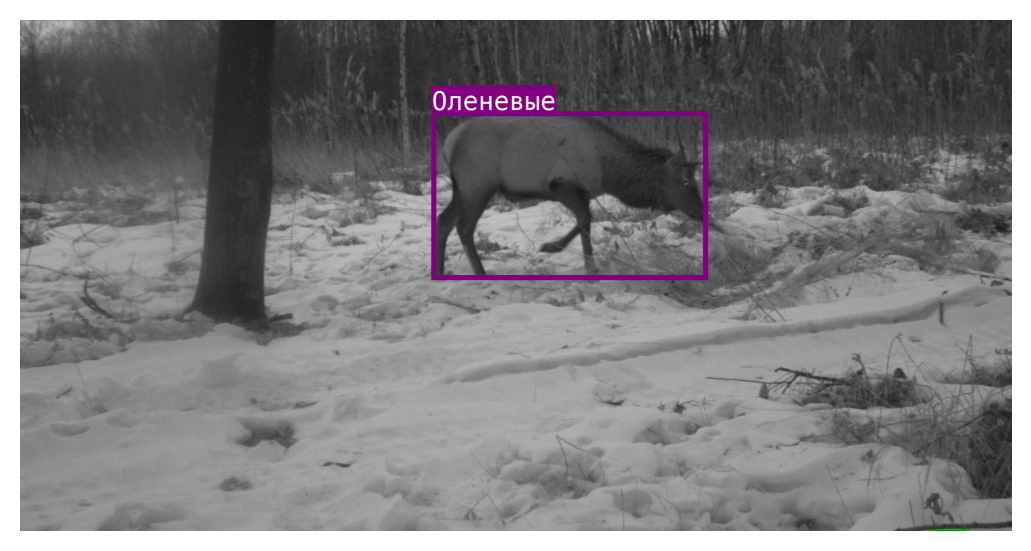

In [40]:
idx = 1 # Индекс строки для визуализации
visualization_by_idx_prediction(dir_test_images, submission_df, idx, MAPPER)